# Measure Kilobots Persistence 

Matan 2019 05 11

The bots seem to be rather persistent, but each has an intrinsic curvature.
Lets measure both the persistence length and the path curvature and the persistence of the curvature too. These are different params.


## Curvature measurement

The radius of curvature between steps 1, 2 and 3 is:

$$ R = \frac{\left|a-b\right|}{2 sin\theta}$$

where $a \equiv r_3-r_1$, and $b\equiv r_3-r_2$, and $\theta$ is the angle between $a$ and $b$.
 
Then we need to computer the radius of curvature for different time intervals, $r\left(t\right)$, $r\left(t+\tau\right)$, $r\left(t+2\tau\right)$: 

$$ \left<R\left(\tau\right)\right>_t = \left<\frac{a\left(t;\tau\right)-b\left(t;\tau\right)}{2 sin\theta\left(t;\tau\right)}\right>_t$$

Alternatively, this can also be parametrized on the curve-length.

###
$$ \left<\vec{V}\left(t\right)\cdot\vec{V}\left(t+\tau\right)\right>_t $$

In [622]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import time

%matplotlib inline
def l2n(x): return np.asarray(x);
import numpy as np
import numba
from matplotlib import pyplot as plt
from numba import njit
from scipy import interpolate

mpl.rc('text',usetex=True)
plt.style.use('dark_background')

params = {'legend.fontsize': 22,
          'figure.figsize': (8, 6),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)

In [589]:
#class calcPersistence:
#    

#@njit    
def _autoCorr(v,maxLag):
    vac = np.zeros(maxLag) #initialize the correlation function
    vMag = np.sum(np.sqrt(v*v),axis=0) #velocity magnitudes
    
    vac[0] = np.mean( np.sum( v*v ,axis=0)/(vMag*vMag));

    for tau in range(1,maxLag):            
        vac[tau] = np.mean( np.sum( v[:,tau:]*v[:,:-tau]/(vMag[tau:]*vMag[:-tau]) ,axis=0));
  
    return vac

def velocityTimeAutoCorrelation(t,r,maxLag=10):
    #Return the autocorelation of an instanteneous veolocity 
    #t - time, x - a position vector
    maxLag = min(maxLag,len(t)-1)

    tt = np.zeros(r.shape[0])+t[:,None]
    tt = tt.T
    v = np.diff(r)/np.diff(tt)

    vac = _autoCorr(v,maxLag)
    return vac

def calcInstantaneousCurvature(r):
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-2)-r)[:,:-2]
    b = (np.roll(r,-1)-r)[:,:-2]
    aNorm = np.linalg.norm(a)
    bNorm = np.linalg.norm(b)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = (a-b)/(2*sinTheta)

    return R


def calcWindowVectorCurvature(r,halfWindow=1):
    
    window=halfWindow*2
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    b = (np.roll(r,-halfWindow)-r)[:,:-window]
    aNorm = np.linalg.norm(a,axis=0)
    bNorm = np.linalg.norm(b,axis=0)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = (a-b)/(2*sinTheta)

    return R

def calcWindowScalarCurvature(r,halfWindow=1):
    
    window=halfWindow*2
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    b = (np.roll(r,-halfWindow)-r)[:,:-window]
    aNorm = np.linalg.norm(a,axis=0)
    bNorm = np.linalg.norm(b,axis=0)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = np.linalg.norm(a-b,axis=0)/(2*sinTheta)

    return R

def calcWindowTangent(r,window=1):
    #computer the local tangent.
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    
    
    return a

# Load Data 

In [595]:
dirName =  './'
fileName = '20190510_50sRun5secTumble_2bots_1fps_5_MED_THRESH_EROD.tif'
locatedDataFileName = fileName+'_loc.csv'
linkedDataFileName = locatedDataFileName+'_link.csv'
tl = pd.read_csv(linkedDataFileName)
tl.head()
#np.roll(z,-2)-z

,frame,Unnamed: 0,objIndex,x,y,pnX,pnY,frame.1,particle,mass
0,0,2,2.0,343.489975,251.617794,NaN,NaN,0,0,798.0
1,0,3,3.0,336.946667,335.806061,NaN,NaN,0,1,825.0
2,1,6,6.0,342.515924,247.785987,NaN,NaN,1,0,785.0
3,1,7,7.0,336.368944,340.321739,NaN,NaN,1,1,805.0
4,2,10,10.0,341.290640,243.979064,NaN,NaN,2,0,812.0


# Calc Curvature 

In [596]:
halfWindow = 20
window=halfWindow*2
x1 = tl[tl.particle==0].x
y1 = tl[tl.particle==0].y

x2 = tl[tl.particle==1].x
y2 = tl[tl.particle==1].y

N1 = len(x1)
N2 = len(x2)

r1 = np.concatenate((x1,y1)).reshape(2,N1)
r2 = np.concatenate((x2,y2)).reshape(2,N2)

R1 = calcWindowScalarCurvature(r1,halfWindow)
R2 = calcWindowScalarCurvature(r2,halfWindow)




# Plot All Together 

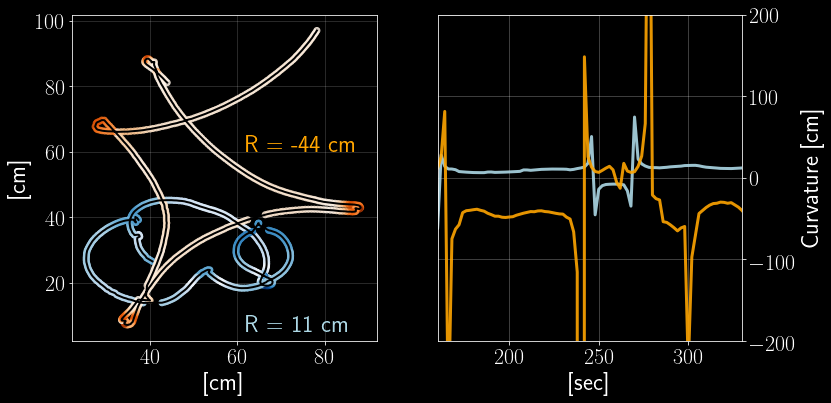

In [646]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

#account for scalebar
ppc = 6.2 #pixels per centimeter
X1 = r1[0,halfWindow*2:]/ppc
Y1 = r1[1,halfWindow*2:]/ppc
X2 = r2[0,halfWindow*2:]/ppc
Y2 = r2[1,halfWindow*2:]/ppc

t1 = np.arange(len(X1))
t2 = np.arange(len(X2))

t1New = t1[::2]
t2New = t2[::2]

R1new = interpolate.interp1d(t1,R1)(t1New)
R2new = interpolate.interp1d(t2,R2)(t2New)

ax[0].scatter(X1,Y1,c=np.roll(1/np.abs(R1),-halfWindow),cmap='Blues',s=ppc*6,alpha=1)
ax[0].scatter(X2,Y2,c=np.roll(1/np.abs(R2),-halfWindow),cmap='Oranges',s=ppc*6,alpha=0.8)

ax[0].plot(X1,Y1,c='k',linewidth=2)#0.5)
ax[0].plot(X2,Y2,c='k',linewidth=2)#0.5)
#ax[0].axis([0,100,0,100])

ax[1].plot(t1New,R1new/ppc,c='LightBlue',linewidth=3,alpha=0.9)
ax[1].plot(t2New,R2new/ppc,c='Orange',linewidth=3,alpha=0.9)
ax[1].axis([160,330,-200,200])
ax[1].grid(alpha=0.3)


ax[0].set_xlabel('[cm]')
ax[0].grid(alpha=0.2)
ax[0].set_ylabel('[cm]')

ax[1].set_xlabel('[sec]')
ax[1].set_ylabel('Curvature [cm]')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[0].text(62,5,'R = 11 cm',fontsize=24,color='LightBlue')
ax[0].text(62,60,'R = -44 cm',fontsize=24,color='Orange')
fig.savefig('curvature2Bots.png')

In [645]:
print(np.median(R1new)/ppc)
print(np.median(R2new)/ppc)

10.931639980744166
-43.91266585350358


# Archive 

In [572]:
aNorm = np.linalg.norm(a,axis=0)
bNorm = np.linalg.norm(b,axis=0)

In [573]:
halfWindow = 2
window=halfWindow*2
a = (np.roll(r,-window)-r)[:,:-window]
b = (np.roll(r,-halfWindow)-r)[:,:-window]
aNorm = np.linalg.norm(a,axis=0)
bNorm = np.linalg.norm(b,axis=0)
sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)
np.cross(a,b,axis=0).size

(np.linalg.norm(a-b)/(2*sinTheta)).size

996

In [574]:
vcR = calcWindowVectorCurvature(r,halfWindow)
scR = calcWindowScalarCurvature(r,halfWindow)

In [575]:
print(vcR[:,0])
print(scR[0])

[  4.2576903 -10.4342209]
-11.269467268228714


In [576]:
np.linalg.norm(vcR[:,:5],axis=0)

array([11.26946727,  8.13754161, 89.87594748, 27.21697709,  9.09304499])

-10.47934408009776


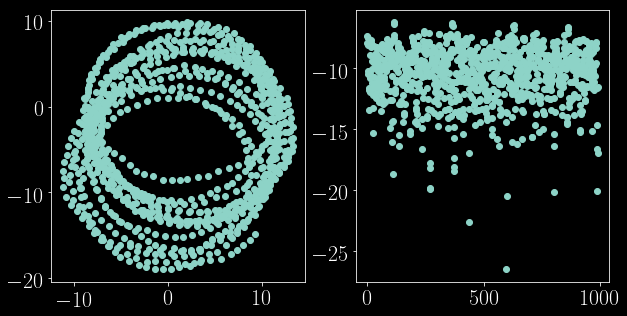

In [590]:
N = 1000

t = np.arange(N)
x = np.cos(t*0.1)+np.cumsum((np.random.rand(N)-0.5))*0.05
y = np.sin(t*0.1)+np.cumsum((np.random.rand(N)-0.5))*0.05

halfWindow = 5
R0 = 10
r = R0*np.concatenate((x,y)).reshape(2,N) 


R = calcWindowScalarCurvature(r,halfWindow)


#np.mean(RNorm)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(r[0,:],r[1,:],'o')

ax[1].plot(R,'o')
#ax[1].axis([0,N,0,10])
#plt.plot(RNorm)
#plt.axis([0,N,0,1E8])

print(np.mean(R))

,frame,Unnamed: 0,objIndex,x,y,pnX,pnY,frame.1,particle,mass
0,0,2,2.0,343.489975,251.617794,NaN,NaN,0,0,798.0
1,0,3,3.0,336.946667,335.806061,NaN,NaN,0,1,825.0
2,1,6,6.0,342.515924,247.785987,NaN,NaN,1,0,785.0
3,1,7,7.0,336.368944,340.321739,NaN,NaN,1,1,805.0
4,2,10,10.0,341.290640,243.979064,NaN,NaN,2,0,812.0


In [580]:
halfWindow = 10
window=halfWindow*2
x1 = t2[t2.particle==0].x
y1 = t2[t2.particle==0].y

N1 = len(x1)
r1 = np.concatenate((x1,y1)).reshape(2,N1)

R1 = calcWindowScalarCurvature(r1,halfWindow)
#R1Norm = np.linalg.norm(R1,axis=0)

#a1 = calcWindowTangent(r1,window=window)

#theta1 = np.arctan(a1[1,:]/a1[0,:])
#plt.plot(theta1)
print(np.median(R1))

64.11375478900945


[0, 379, -100, 200]

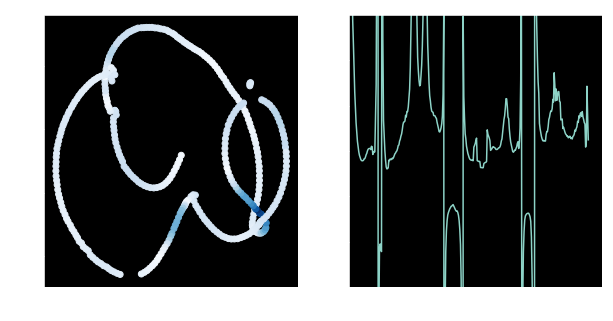

In [581]:

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(r1[0,halfWindow*2:],r1[1,halfWindow*2:],c=1/np.abs(R1),cmap='Blues')

ax[1].plot(R1)
ax[1].axis([0,N1,-100,200])


In [582]:
halfWindow = 4
window = halfWindow*2
x2 = t2[t2.particle==1].x
y2 = t2[t2.particle==1].y

N2 = len(x2)
r2 = np.concatenate((x2,y2)).reshape(2,N2)

R2 = calcWindowScalarCurvature(r2,halfWindow)


ValueError: 'c' argument has 359 elements, which is not acceptable for use with 'x' with size 371, 'y' with size 371.

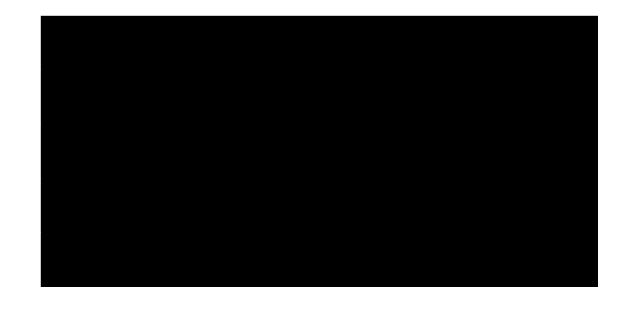

In [583]:

fig,ax = plt.subplots(1,1,figsize=(10,5))


img0 = ax.scatter(r1[0,halfWindow*2:],r1[1,halfWindow*2:],c=1/R1*ppc,cmap='spring')


#ax[1].plot(R2)
fig.colorbar(img0, ax=ax)
print(np.median(R2))
#ax[1].axis([0,N,-10000,10000])

-276.9397859391262


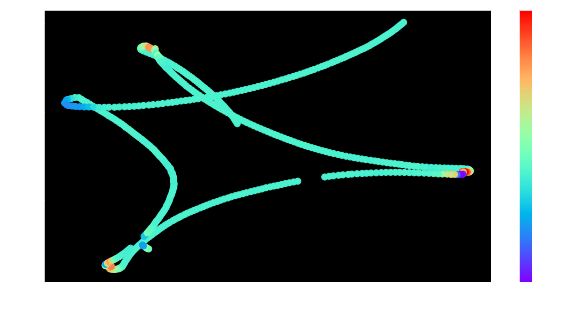

In [584]:

fig,ax = plt.subplots(1,1,figsize=(10,5))


img0 = ax.scatter(r2[0,halfWindow*2:],r2[1,halfWindow*2:],c=1/R2*ppc,cmap='rainbow')


#ax[1].plot(R2)
fig.colorbar(img0, ax=ax)
print(np.median(R2))
#ax[1].axis([0,N,-10000,10000])

-276.9397859391262


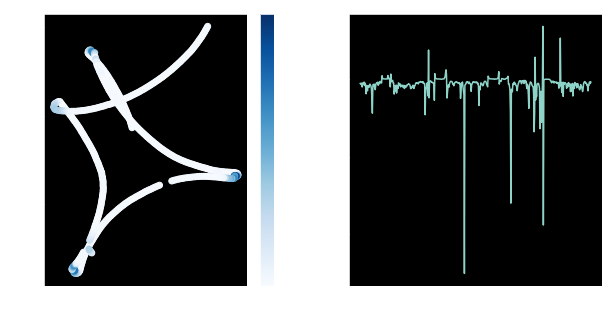

In [585]:

fig,ax = plt.subplots(1,2,figsize=(10,5))


img0 = ax[0].scatter(r2[0,halfWindow*2:],r2[1,halfWindow*2:],c=1/np.abs(R2),cmap='Blues')


ax[1].plot(R2)
fig.colorbar(img0, ax=ax[0])
print(np.median(R2))
#ax[1].axis([0,N,-10000,10000])

[0, 379, -100, 100]

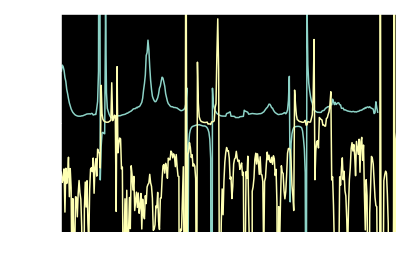

In [586]:
ppc = 6.2  #pixels per centimer
plt.plot(R1/ppc)
plt.plot(R2/ppc)

plt.axis([0,N1,-100,100])

## Plot all together 

ValueError: x and y arrays must be equal in length along interpolation axis.

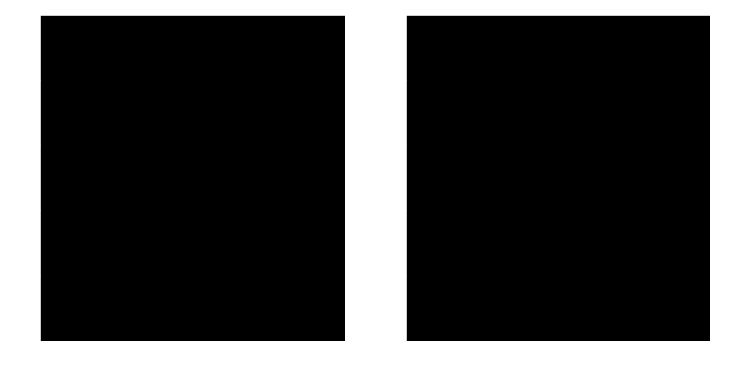

In [587]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

#account for scalebar
ppc = 6.2 #pixels per centimeter
X1 = r1[0,halfWindow*2:]/ppc
Y1 = r1[1,halfWindow*2:]/ppc
X2 = r2[0,halfWindow*2:]/ppc
Y2 = r2[1,halfWindow*2:]/ppc


t1 = np.arange(len(X1))
t2 = np.arange(len(X2))

t1New = t1[::2]
t2New = t2[::2]

R1new = interpolate.interp1d(t1,R1)(t1New)
R2new = interpolate.interp1d(t2,R2)(t2New)

ax[0].scatter(X1,Y1,c=1/np.abs(R1),cmap='Blues',s=ppc*6,alpha=1)
ax[0].scatter(X2,Y2,c=1/np.abs(R2),cmap='Oranges',s=ppc*6,alpha=0.8)

ax[0].plot(X1,Y1,c='k',linewidth=2)#0.5)
ax[0].plot(X2,Y2,c='k',linewidth=2)#0.5)
#ax[0].axis([0,100,0,100])

ax[1].plot(t1New,R1new/ppc,c='LightBlue',linewidth=2,alpha=0.9)
ax[1].plot(t2New,R2new/ppc,c='Orange',linewidth=2,alpha=0.9)
ax[1].axis([0,N2,-150,100])

ax[0].set_xlabel('[cm]')
ax[1].set_xlabel('[sec]')
ax[0].set_ylabel('[cm]')
ax[0].grid(alpha=0.2)

In [568]:
X1

array([53.97775445, 53.70826436, 53.45702967, 53.1660921 , 52.92392507,
       52.66871415, 52.46205529, 52.22307342, 51.9776831 , 51.71236559,
       51.4300936 , 51.11046943, 50.7925078 , 50.44245578, 50.10690173,
       49.76224302, 49.35399315, 48.944641  , 48.49833148, 48.05269923,
       47.57399401, 47.02747298, 46.45757086, 45.81202759, 45.1967455 ,
       44.50108641, 43.85492206, 43.27571983, 42.64637149, 42.09028911,
       41.55342477, 41.05877565, 40.48450431, 40.01333503, 39.59301354,
       39.15496521, 38.84081346, 38.54479222, 38.23211781, 37.9639777 ,
       37.71983448, 37.48159057, 37.30945952, 37.22112227, 37.11105991,
       37.03364055, 36.97162361, 37.0148918 , 37.56439576, 37.46208714,
       37.29134665, 37.26031358, 36.33961719, 36.11792411, 35.86597059,
       35.72944707, 35.56627886, 35.42237493, 35.3674735 , 35.3212604 ,
       35.25084655, 35.25587828, 35.31315743, 35.36928718, 35.5003068 ,
       35.65633098, 35.76159965, 35.99248785, 36.1750218 , 36.48

[0, 379, -200, 200]

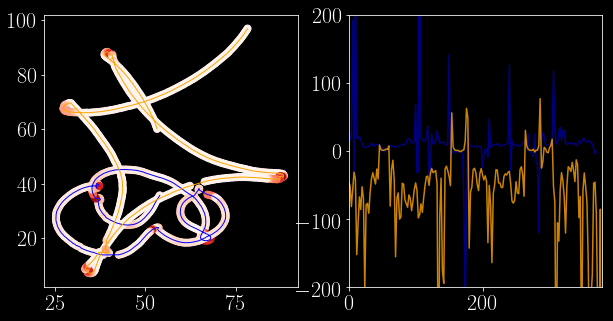

In [519]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

#account for scalebar
ppc = 6.2 #pixels per centimeter

X1 = r1[0,halfWindow*2:]/ppc
Y1 = r1[1,halfWindow*2:]/ppc
X2 = r2[0,halfWindow*2:]/ppc
Y2 = r2[1,halfWindow*2:]/ppc

t1 = np.arange(len(X1))
t2 = np.arange(len(X2))

t1New = t1[::2]
t2New = t2[::2]

R1new = interpolate.interp1d(t1,R1)(t1New)
R2new = interpolate.interp1d(t2,R2)(t2New)
ax[0].scatter(X1,Y1,c=1/np.abs(R1),cmap='Reds',s=50)
ax[0].scatter(X2,Y2,c=1/np.abs(R2),cmap='Reds',s=50)

ax[0].plot(X1,Y1,c='blue',linewidth=1)#0.5)
ax[0].plot(X2,Y2,c='orange',linewidth=1)#0.5)

ax[1].plot(t1New,R1new/ppc,c='Blue',alpha=0.5)
ax[1].plot(t2New,R2new/ppc,c='Orange',alpha=0.8)
ax[1].axis([0,N1,-200,200])


In [514]:
t1=np.arange(len(X1))
f = interpolate.interp1d(t1,R1/ppc)
t1=t1[::5]
f(t1)

array([ 38.95398679,  43.18106665, 284.04441562,  17.88576446,
        10.61732258,   4.95266885,   6.70189565,  12.62604758,
         9.53648129,   7.76183487,   5.01743237,  -1.31839755,
         6.8593915 ,   5.94997997,   5.94080117,   7.34537534,
         9.81571363,   8.94050253,  18.37804017,   8.94847371,
        69.10436587, -67.53240713,  16.63691456,  16.1136387 ,
       -34.5371241 ,  17.94019611,  16.35980233,  16.28951257,
        13.70942728,   9.48483951, 142.4767858 ,  -1.69645279,
        -1.68270786,  -1.15396809,  -4.02878243, -39.64955766,
        10.18383921,   6.21750818,   7.05423766,   5.73465237,
       -24.43591135,   2.42309412,  47.54089521,   7.646237  ,
         9.18196353,   7.86173403,   8.70764852,   9.37210922,
       126.36471809,   9.66883483,   8.61608971,   6.58466387,
        11.46647953,  12.82359959,  -1.50181959,  -5.00770406,
       -14.47789346,  62.6937611 ,  27.42459114,   8.93369422,
         8.61119246,  33.68246745,  10.6434108 ,  13.40

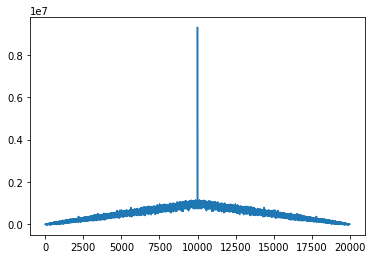

In [23]:
vx = v[0,:]
vxac = np.correlate(vx,vx,mode='full')
vy = v[1,:]
vxac = np.correlate(vy,vy,mode='full')
plt.plot(vxac)

In [11]:
N = 10000
t = np.arange(N)
x = 10*t + ( (np.random.rand(N)-0.5)*100 ).cumsum()
y = 10*t + ( (np.random.rand(N)-0.5)*100 ).cumsum()


r = np.concatenate((x,y)).reshape(2,N)

maxLag= 1000
#Return the autocorelation of an instanteneous veolocity 
#t - time, x - a position vector
maxLag = min(maxLag,len(t)-1)


tt = np.zeros(r.shape[0])+t[:,None]
tt = tt.T
v = np.diff(r)/np.diff(tt)


vac = np.zeros(maxLag) #initialize the correlation function
vac[0] = np.mean( np.sum( v*v ,axis=0));
for tau in range(1,maxLag):            
    vac[tau] = np.mean( np.sum( v[:,tau:]*v[:,:-tau] ,axis=0));

